In [1]:
%matplotlib notebook
import os
import matplotlib.pyplot as plt
import numpy as np
import lal
import lalsimulation as lalsim
import sys
sys.path.append('../scripts')
import compute_sigmalm0_SimIMREOBGenerateQNMFreqV2 as calcqnm
import scipy
import scipy.signal as ss
from scipy import interpolate
import scipy.ndimage.filters as filter
from optparse import OptionParser
import corner

In [2]:
# Module for confidence calculations
class confidence(object):
    def __init__(self, counts):
        # Sort in descending order in frequency
        self.counts_sorted = np.sort(counts.flatten())[::-1]
        # Get a normalized cumulative distribution from the mode
        self.norm_cumsum_counts_sorted = np.cumsum(self.counts_sorted) / np.sum(counts)
        # Set interpolations between heights, bins and levels
        self._set_interp()
    def _set_interp(self):
        self._length = len(self.counts_sorted)
        # height from index
        self._height_from_idx = interpolate.interp1d(np.arange(self._length), self.counts_sorted, bounds_error=False, fill_value=0.)
        # index from height
        self._idx_from_height = interpolate.interp1d(self.counts_sorted[::-1], np.arange(self._length)[::-1], bounds_error=False, fill_value=self._length)
        # level from index
        self._level_from_idx = interpolate.interp1d(np.arange(self._length), self.norm_cumsum_counts_sorted, bounds_error=False, fill_value=1.)
        # index from level
        self._idx_from_level = interpolate.interp1d(self.norm_cumsum_counts_sorted, np.arange(self._length), bounds_error=False, fill_value=self._length)
    def level_from_height(self, height):
        return self._level_from_idx(self._idx_from_height(height))
    def height_from_level(self, level):
        return self._height_from_idx(self._idx_from_level(level))

# gaussian filter of histogram
def gf(P):
    return filter.gaussian_filter(P, sigma=1.0)


# 
def P_xy_2dhist(x, y, N_bins):
    x_bins = np.linspace(min(x), max(x), N_bins)
    y_bins = np.linspace(min(y), max(y), N_bins)

    dx = np.mean(np.diff(x_bins))
    dy = np.mean(np.diff(y_bins))

    x_intp = (x_bins[:-1] + x_bins[1:])/2.
    y_intp = (y_bins[:-1] + y_bins[1:])/2.
    
    P_xy, x_bins, y_bins = np.histogram2d(x, y, bins=(x_bins, y_bins), normed=True)
    P_xy = P_xy.T
    
    conf = confidence(P_xy)
    s1 = conf.height_from_level(0.5)
    s2 = conf.height_from_level(0.9)
    
    return P_xy, x_intp, y_intp, s1, s2

# GW150914

## Real data

In [ ]:
seob_loc = '/Users/abhirupghosh/Documents/Work/spinqnm/spinqnm/data/S190521g/pSEOBNRv4HM_frac_220.dat'
data = np.genfromtxt(seob_loc, names=True, dtype=None)
m1, m2, domega, dtau = data['m1'], data['m2'], data['domega220'], data['dtau220']
a1z, a2z = np.zeros(len(m1)), np.zeros(len(m2))

lm = [2,2]

# create (omega, tau) GR and modGRarrays
omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
freq_GR = omega_GR/(2.*np.pi)

omega_modGR, tau_modGR = calcqnm.get_sigmalm0SI_modGR(omega_GR, tau_GR, domega, dtau)
freq_modGR = omega_modGR/(2.*np.pi)

f_seob = freq_modGR
tau_seob = tau_modGR
samples_seob = np.vstack((f_eob, tau_eob)).T

In [3]:
seob_loc = '/Users/abhirupghosh/Documents/Work/spinqnm/spinqnm/data/GW150914/pSEOBNRv4HM_frac_220.dat'
data = np.genfromtxt(seob_loc, names=True, dtype=None)
m1, m2, a1z, a2z, domega, dtau = data['m1'], data['m2'], data['a1z'], data['a2z'], data['domega220'], data['dtau220']
lm = [2,2]

# create (omega, tau) GR and modGRarrays
omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
freq_GR = omega_GR/(2.*np.pi)

omega_modGR, tau_modGR = calcqnm.get_sigmalm0SI_modGR(omega_GR, tau_GR, domega, dtau)
freq_modGR = omega_modGR/(2.*np.pi)

f_seob = freq_modGR
tau_seob = tau_modGR
samples_seob = np.vstack((f_seob, tau_seob)).T

In [4]:
eob_loc = '/Users/abhirupghosh/Documents/Work/spinqnm/spinqnm/data/GW150914/pEOBNRv2HM_frac_richard_220.dat'
data = np.genfromtxt(eob_loc, names=True, dtype=None)
m1, m2, domega, dtau = data['m1'], data['m2'], data['domega220'], data['dtau220']
a1z, a2z = np.zeros(len(m1)), np.zeros(len(m2))

lm = [2,2]

# create (omega, tau) GR and modGRarrays
omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
freq_GR = omega_GR/(2.*np.pi)

omega_modGR, tau_modGR = calcqnm.get_sigmalm0SI_modGR(omega_GR, tau_GR, domega, dtau)
freq_modGR = omega_modGR/(2.*np.pi)

f_eob = freq_modGR
tau_eob = tau_modGR
samples_eob = np.vstack((f_eob, tau_eob)).T

In [5]:
td_loc = '/Users/abhirupghosh/Documents/Work/spinqnm/spinqnm/data/GW150914/gregorio_220.dat'
data = np.genfromtxt(td_loc, names=True, dtype=None)

f_td = data['f0']
tau_td = data['tau0']
samples_td = np.vstack((f_td, tau_td)).T

<IPython.core.display.Javascript object>


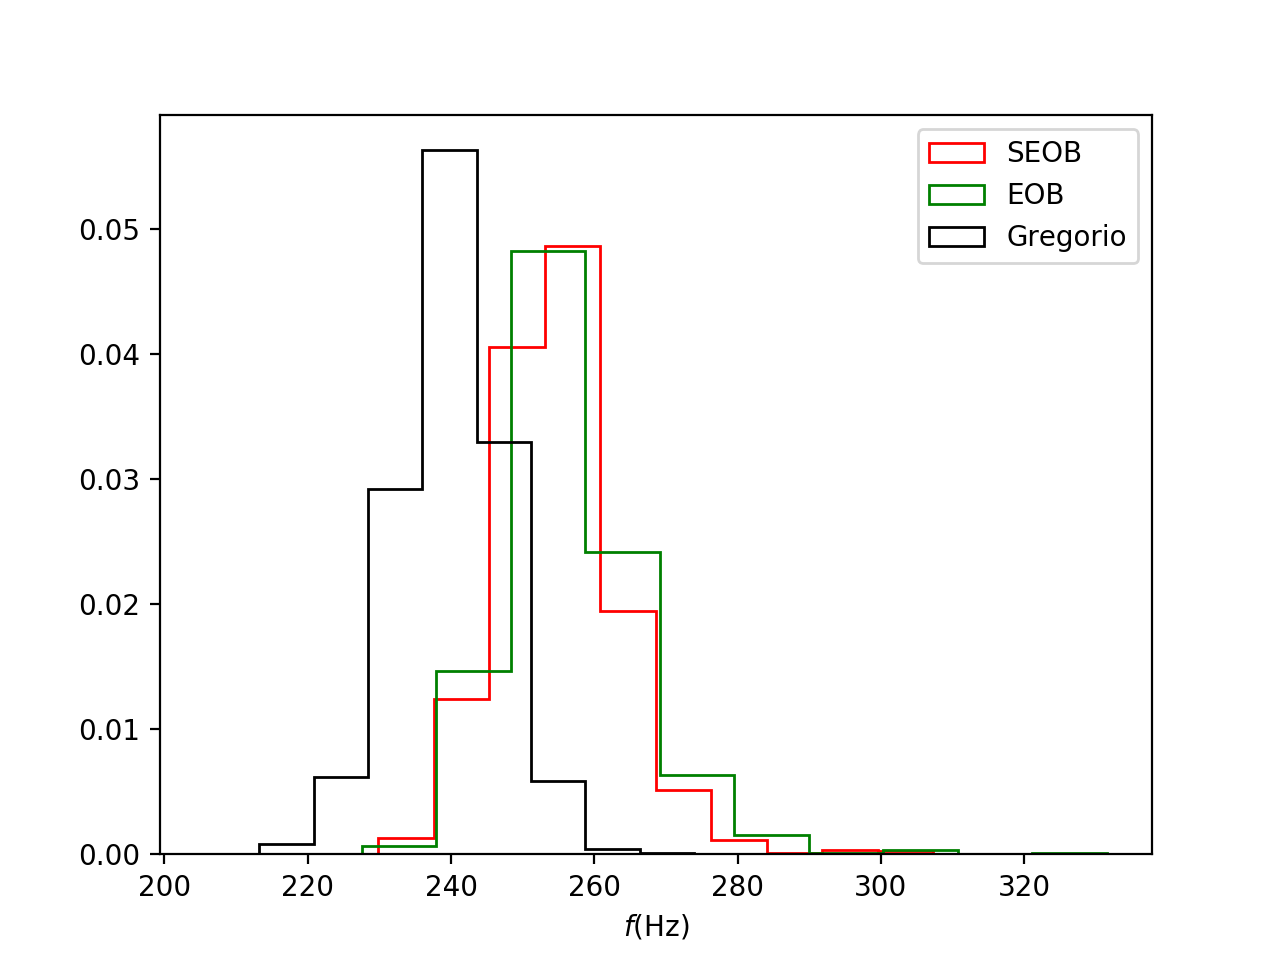

In [6]:
plt.figure()
plt.hist(f_seob, histtype='step', label='SEOB', normed=True, color='r')
plt.hist(f_eob, histtype='step', label='EOB', normed=True, color='g')
plt.hist(f_td, histtype='step', label='Gregorio', normed=True, color='k')
plt.xlabel("$f$(Hz)")
plt.legend(loc='best')

<IPython.core.display.Javascript object>


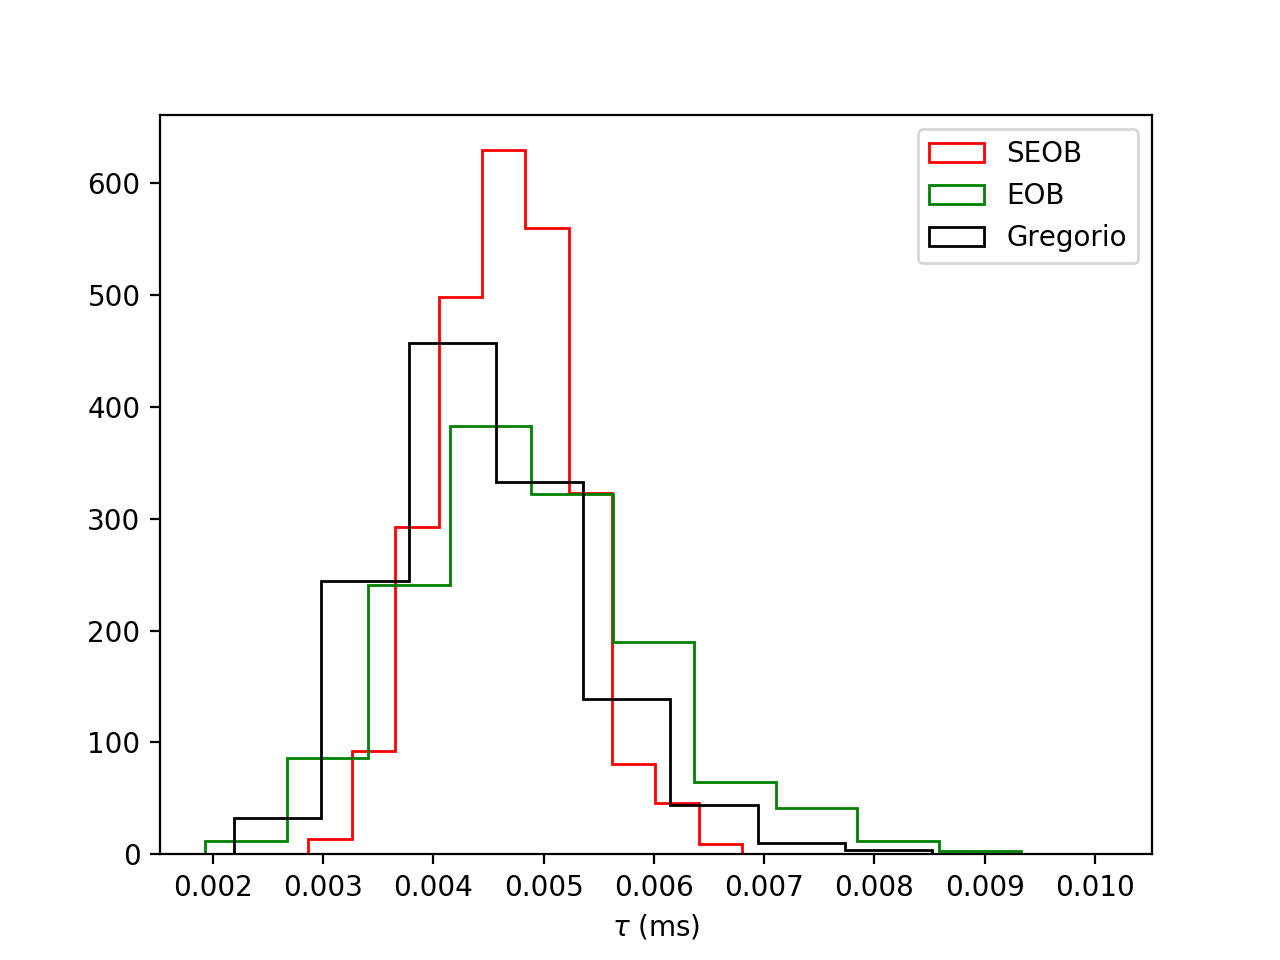

In [7]:
plt.figure()
plt.hist(tau_seob, histtype='step', label='SEOB', normed=True, color='r')
plt.hist(tau_eob, histtype='step', label='EOB', normed=True, color='g')
plt.hist(tau_td, histtype='step', label='Gregorio', normed=True, color='k')
plt.xlabel(r"$\tau$ (ms)")
plt.legend(loc='best')

<IPython.core.display.Javascript object>


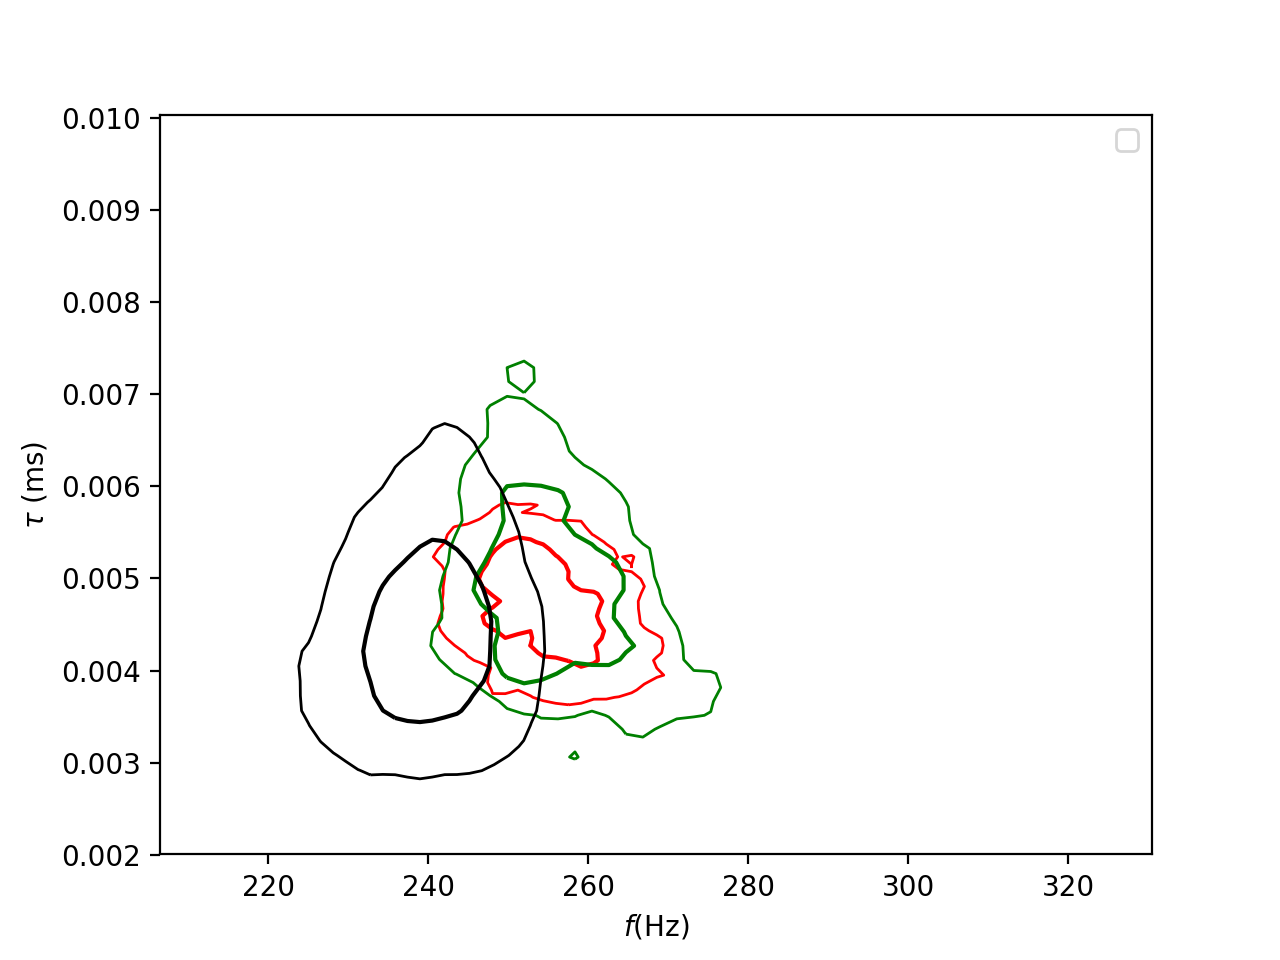

/Users/abhirupghosh/src/pycbc/lib/python2.7/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'labels'
  s)
/Users/abhirupghosh/src/pycbc/lib/python2.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  """
/Users/abhirupghosh/src/pycbc/lib/python2.7/site-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/Users/abhirupghosh/src/pycbc/lib/python2.7/site-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)
/Users/abhirupghosh/src/pycbc/lib/python2.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Fu

In [8]:
plt.figure()

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_seob, tau_seob, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='r', labels='SEOB')
plt.hold(True)

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_eob, tau_eob, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='g', labels='EOB')
plt.hold(True)

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_td, tau_td, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='k', labels='Gregorio')
plt.legend(loc='best')
plt.xlabel("$f$(Hz)")
plt.ylabel(r"$\tau$ (ms)")
plt.show()

## Software Injection

In [43]:
seob_loc = '/Users/abhirupghosh/Documents/Work/spinqnm/spinqnm/data/GW150914/SXS_007_pSEOBNR.dat'
data = np.genfromtxt(seob_loc, names=True, dtype=None)
m1, m2, a1z, a2z, domega, dtau = data['m1'], data['m2'], data['a1z'], data['a2z'], data['domega220'], data['dtau220']
lm = [2,2]

# create (omega, tau) GR and modGRarrays
omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
freq_GR = omega_GR/(2.*np.pi)

omega_modGR, tau_modGR = calcqnm.get_sigmalm0SI_modGR(omega_GR, tau_GR, domega, dtau)
freq_modGR = omega_modGR/(2.*np.pi)

f_seob = freq_modGR
tau_seob = tau_modGR
samples_seob = np.vstack((f_seob, tau_seob)).T

In [44]:
eob_loc = '/Users/abhirupghosh/Documents/Work/spinqnm/spinqnm/data/GW150914/SXS_007_pEOBNR.txt'
f_eob, tau_eob = np.loadtxt(eob_loc, unpack=True)
tau_eob = tau_eob/1000.
samples_seob = np.vstack((f_seob, tau_seob)).T

<IPython.core.display.Javascript object>


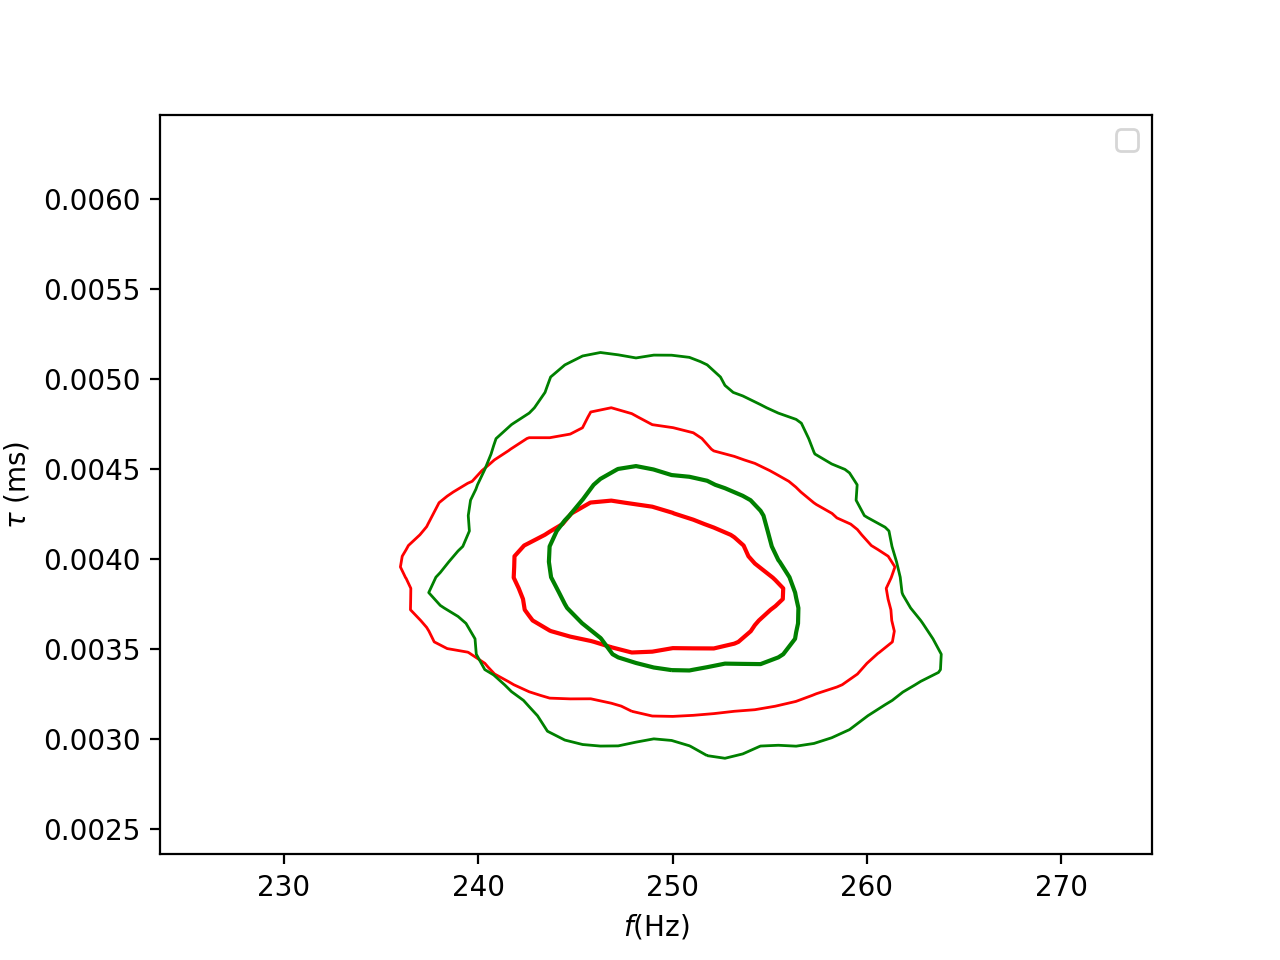

/Users/abhirupghosh/src/pycbc/lib/python2.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  """
/Users/abhirupghosh/src/pycbc/lib/python2.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if __name__ == '__main__':


In [45]:
plt.figure()

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_seob, tau_seob, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='r', labels='SEOB')
plt.hold(True)

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_eob, tau_eob, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='g', labels='EOB')
plt.hold(True)

#P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_td, tau_td, 50)
#plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='k', labels='Gregorio')
plt.legend(loc='best')
plt.xlabel("$f$(Hz)")
plt.ylabel(r"$\tau$ (ms)")
plt.show()

# S190521g

## Real data

In [9]:
eob_loc = '/Users/abhirupghosh/Documents/Work/spinqnm/spinqnm/data/S190521g/pEOBNRv2HM_frac_richard_220.dat'
data = np.genfromtxt(eob_loc, names=True, dtype=None)
m1, m2, domega, dtau = data['m1'], data['m2'], data['domega220'], data['dtau220']
a1z, a2z = np.zeros(len(m1)), np.zeros(len(m2))

lm = [2,2]

# create (omega, tau) GR and modGRarrays
omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
freq_GR = omega_GR/(2.*np.pi)

omega_modGR, tau_modGR = calcqnm.get_sigmalm0SI_modGR(omega_GR, tau_GR, domega, dtau)
freq_modGR = omega_modGR/(2.*np.pi)

f_eob = freq_modGR
tau_eob = tau_modGR
samples_eob = np.vstack((f_eob, tau_eob)).T

In [10]:
td_loc = '/Users/abhirupghosh/Documents/Work/spinqnm/spinqnm/data/S190521g/gregorio_220.dat'
data = np.genfromtxt(td_loc, names=True, dtype=None)

f_td = data['f0']
tau_td = data['tau0']
samples_td = np.vstack((f_td, tau_td)).T

<IPython.core.display.Javascript object>


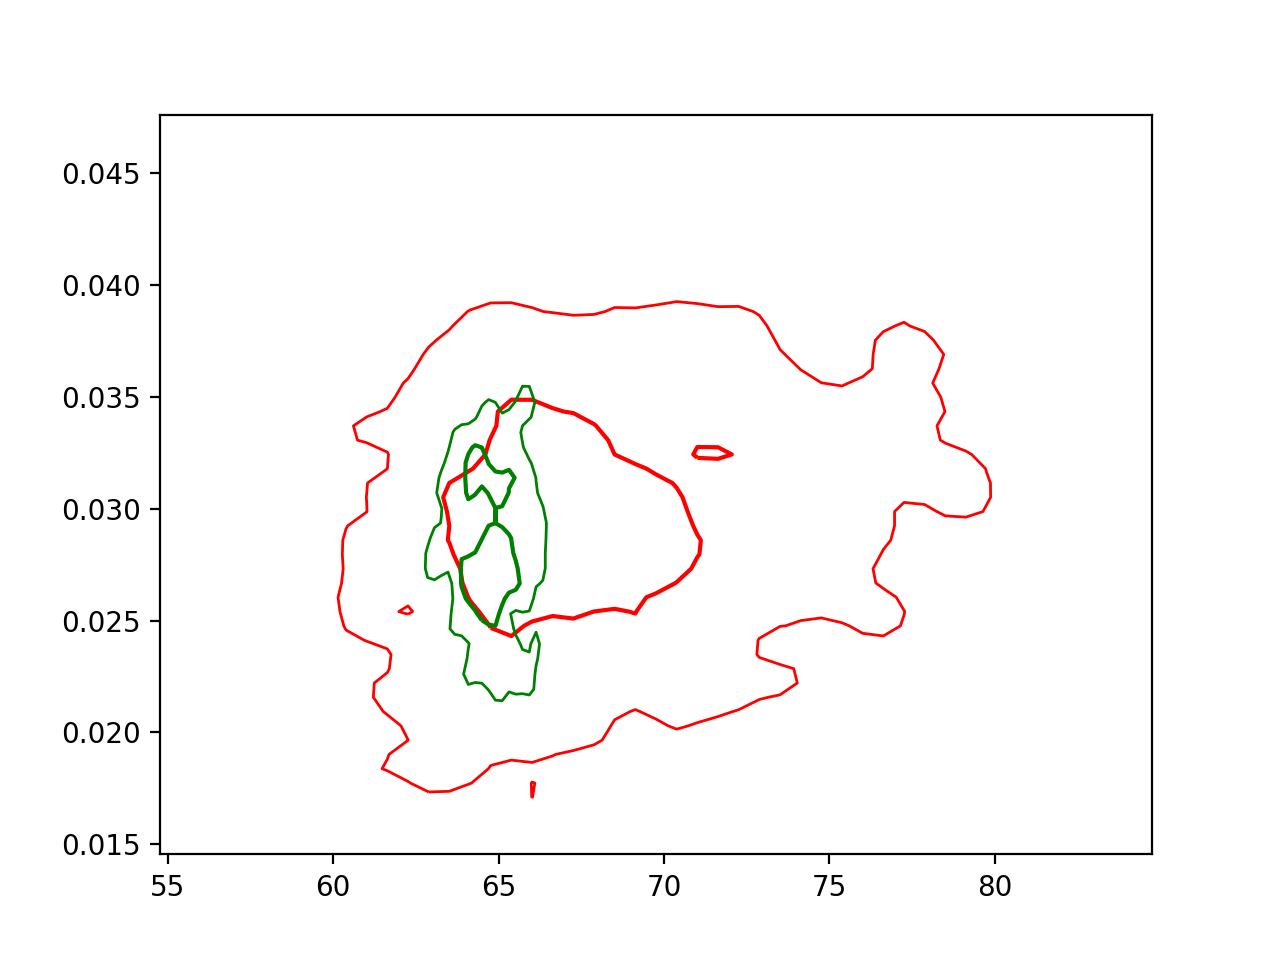

/Users/abhirupghosh/src/pycbc/lib/python2.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  """
/Users/abhirupghosh/src/pycbc/lib/python2.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if __name__ == '__main__':


In [12]:
plt.figure()

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_seob, tau_seob, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='r', labels='SEOB')
plt.hold(True)

P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_eob, tau_eob, 50)
plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='g', labels='EOB')
plt.hold(True)

#P_xy, x_intp, y_intp, s1, s2 = P_xy_2dhist(f_td, tau_td, 50)
#plt.contour(x_intp,y_intp,gf(P_xy), levels=(s2,s1), linewidths=(1,1.5), colors='k', labels='Gregorio')
#plt.legend(loc='best')
#plt.xlabel("$f$(Hz)")
#plt.ylabel(r"$\tau$ (ms)")
plt.show()